In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Dataset

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

width, height = 224, 224  # MobileNetV2 sử dụng kích thước ảnh 224x224
classes = 33
batch_size = 64

# ImageDataGenerator setup
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True # Trộn
)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12897 images belonging to 33 classes.
Found 2822 images belonging to 33 classes.
Found 2856 images belonging to 33 classes.


### Model Structure

In [ ]:
# Tải mô hình base model và đóng băng các lớp đầu tiên
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(height, width, 3))

# Đóng băng một số lớp đầu để giữ lại các đặc trưng cơ bản
for layer in base_model.layers[:-20]:  # Chỉ bỏ khóa các lớp cuối (tuning)
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(256, kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

### Training : Transfer Learning

In [3]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('animal_mobilenetv2_model.h5', save_best_only=True, monitor='val_loss', verbose=1)

# Optimizer and compiling model
learning_rate = 0.01
opt = SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
H = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    verbose=1,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/30
201/201 [==============================] - ETA: 0s - loss: 1.5254 - accuracy: 0.7036
Epoch 1: val_loss improved from inf to 1.52534, saving model to animal_mobilenetv2_model.h5
201/201 [==============================] - 203s 982ms/step - loss: 1.5254 - accuracy: 0.7036 - val_loss: 1.5253 - val_accuracy: 0.7766 - lr: 0.0100
Epoch 2/30
201/201 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.8197
Epoch 2: val_loss improved from 1.52534 to 1.23710, saving model to animal_mobilenetv2_model.h5
201/201 [==============================] - 142s 703ms/step - loss: 1.0085 - accuracy: 0.8197 - val_loss: 1.2371 - val_accuracy: 0.8114 - lr: 0.0100
Epoch 3/30
201/201 [==============================] - ETA: 0s - loss: 0.8954 - accuracy: 0.8418
Epoch 3: val_loss improved from 1.23710 to 1.02059, saving model to animal_mobilenetv2_model.h5
201/201 [==============================] - 117s 583ms/step - loss: 0.8954 - accuracy: 0.8418 - val_loss: 1.0206 - val_accuracy: 0.85

### Display model performance

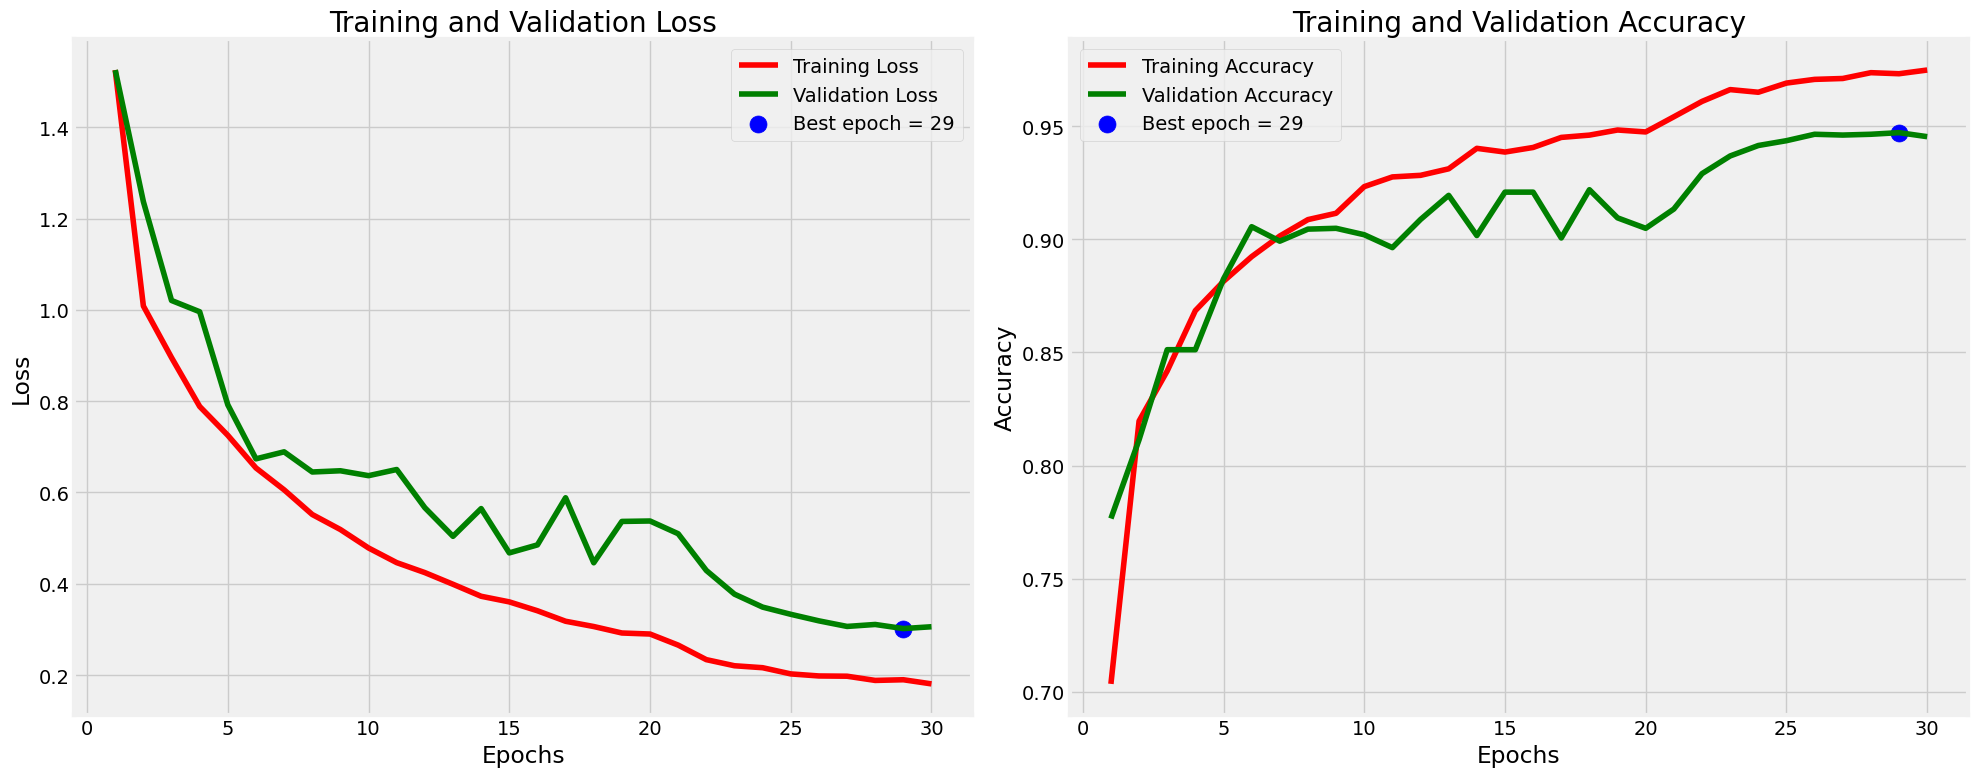

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Giả sử `H` là lịch sử huấn luyện của mô hình từ model.fit()
tr_acc = H.history['accuracy']
tr_loss = H.history['loss']
val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

# Tìm epoch có val_loss thấp nhất và val_accuracy cao nhất
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Vẽ biểu đồ lịch sử huấn luyện
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Evaluate the model on the test set

In [ ]:
eval_result = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

45/45 [==============================] - 5s 100ms/step - loss: 0.3168 - accuracy: 0.9478
Test Loss: 0.3168284595012665, Test Accuracy: 0.9478291273117065


### F1 Score / Recall / Precision

In [6]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Dự đoán trên tập kiểm tra
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Chọn lớp có xác suất cao nhất

# Lấy nhãn thực tế từ test_generator
y_true = test_generator.classes  # Các nhãn thực tế của tập kiểm tra

# Tính F1 Score (macro)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score (macro):", f1)

# In báo cáo phân loại (Precision, Recall, F1 Score cho từng lớp)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

45/45 [==============================] - 5s 85ms/step
F1 Score (macro): 0.9461889301214863
              precision    recall  f1-score   support

         Ant       0.99      0.84      0.91        80
    Antelope       0.87      0.94      0.91        86
        Bear       0.99      0.85      0.91        78
         Bee       0.99      0.98      0.98        87
      Beetle       0.92      0.99      0.95        80
        Bull       0.96      0.85      0.90        86
   Butterfly       0.95      1.00      0.98        84
       Camel       0.93      0.94      0.94        86
         Cat       0.91      0.97      0.94        87
     Chicken       0.98      0.97      0.97        94
   Crocodile       0.98      0.97      0.97        95
         Dog       0.93      0.96      0.95        90
        Duck       0.97      0.95      0.96        80
    Elephant       0.95      1.00      0.97       106
        Fish       0.95      0.97      0.96        79
        Frog       0.97      0.95      0.96 

### Get Predictions

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

# Dự đoán nhãn và xác suất cao nhất cho mỗi mẫu trong tập kiểm tra
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_prob = np.asarray(tf.reduce_max(model.predict(test_generator), axis=1))

# Tạo DataFrame với các thông tin dự đoán
Predictions = pd.DataFrame({
    "Image Index": list(range(len(test_generator.filenames))),
    "Test Labels": test_generator.classes,
    "Test Classes": [classes[i] for i in test_generator.classes],
    "Prediction Labels": y_pred,
    "Prediction Classes": [classes[i] for i in y_pred],
    "Path": test_generator.filenames,
    "Prediction Probability": y_prob
})

Predictions.head(8)

45/45 [==============================] - 4s 80ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0            0          Ant                  0   
1            1            0          Ant                  0   
2            2            0          Ant                  0   
3            3            0          Ant                  0   
4            4            0          Ant                  0   
5            5            0          Ant                 29   
6            6            0          Ant                 27   
7            7            0          Ant                  6   

  Prediction Classes             Path  Prediction Probability  
0                Ant    Ant\Ant_1.jpg                0.999999  
1                Ant   Ant\Ant_10.jpg                0.999987  
2                Ant  Ant\Ant_104.jpg                0.989025  
3                Ant   Ant\Ant_11.jpg                0.999355  
4                Ant  Ant\Ant_115.jpg                0.999989  
5             Spider  Ant\Ant_116.jpg                0.595908  
6              Snail  Ant\Ant_117.jpg                0.312719  
7          Butterfly  Ant\Ant_118.jpg                0.569979

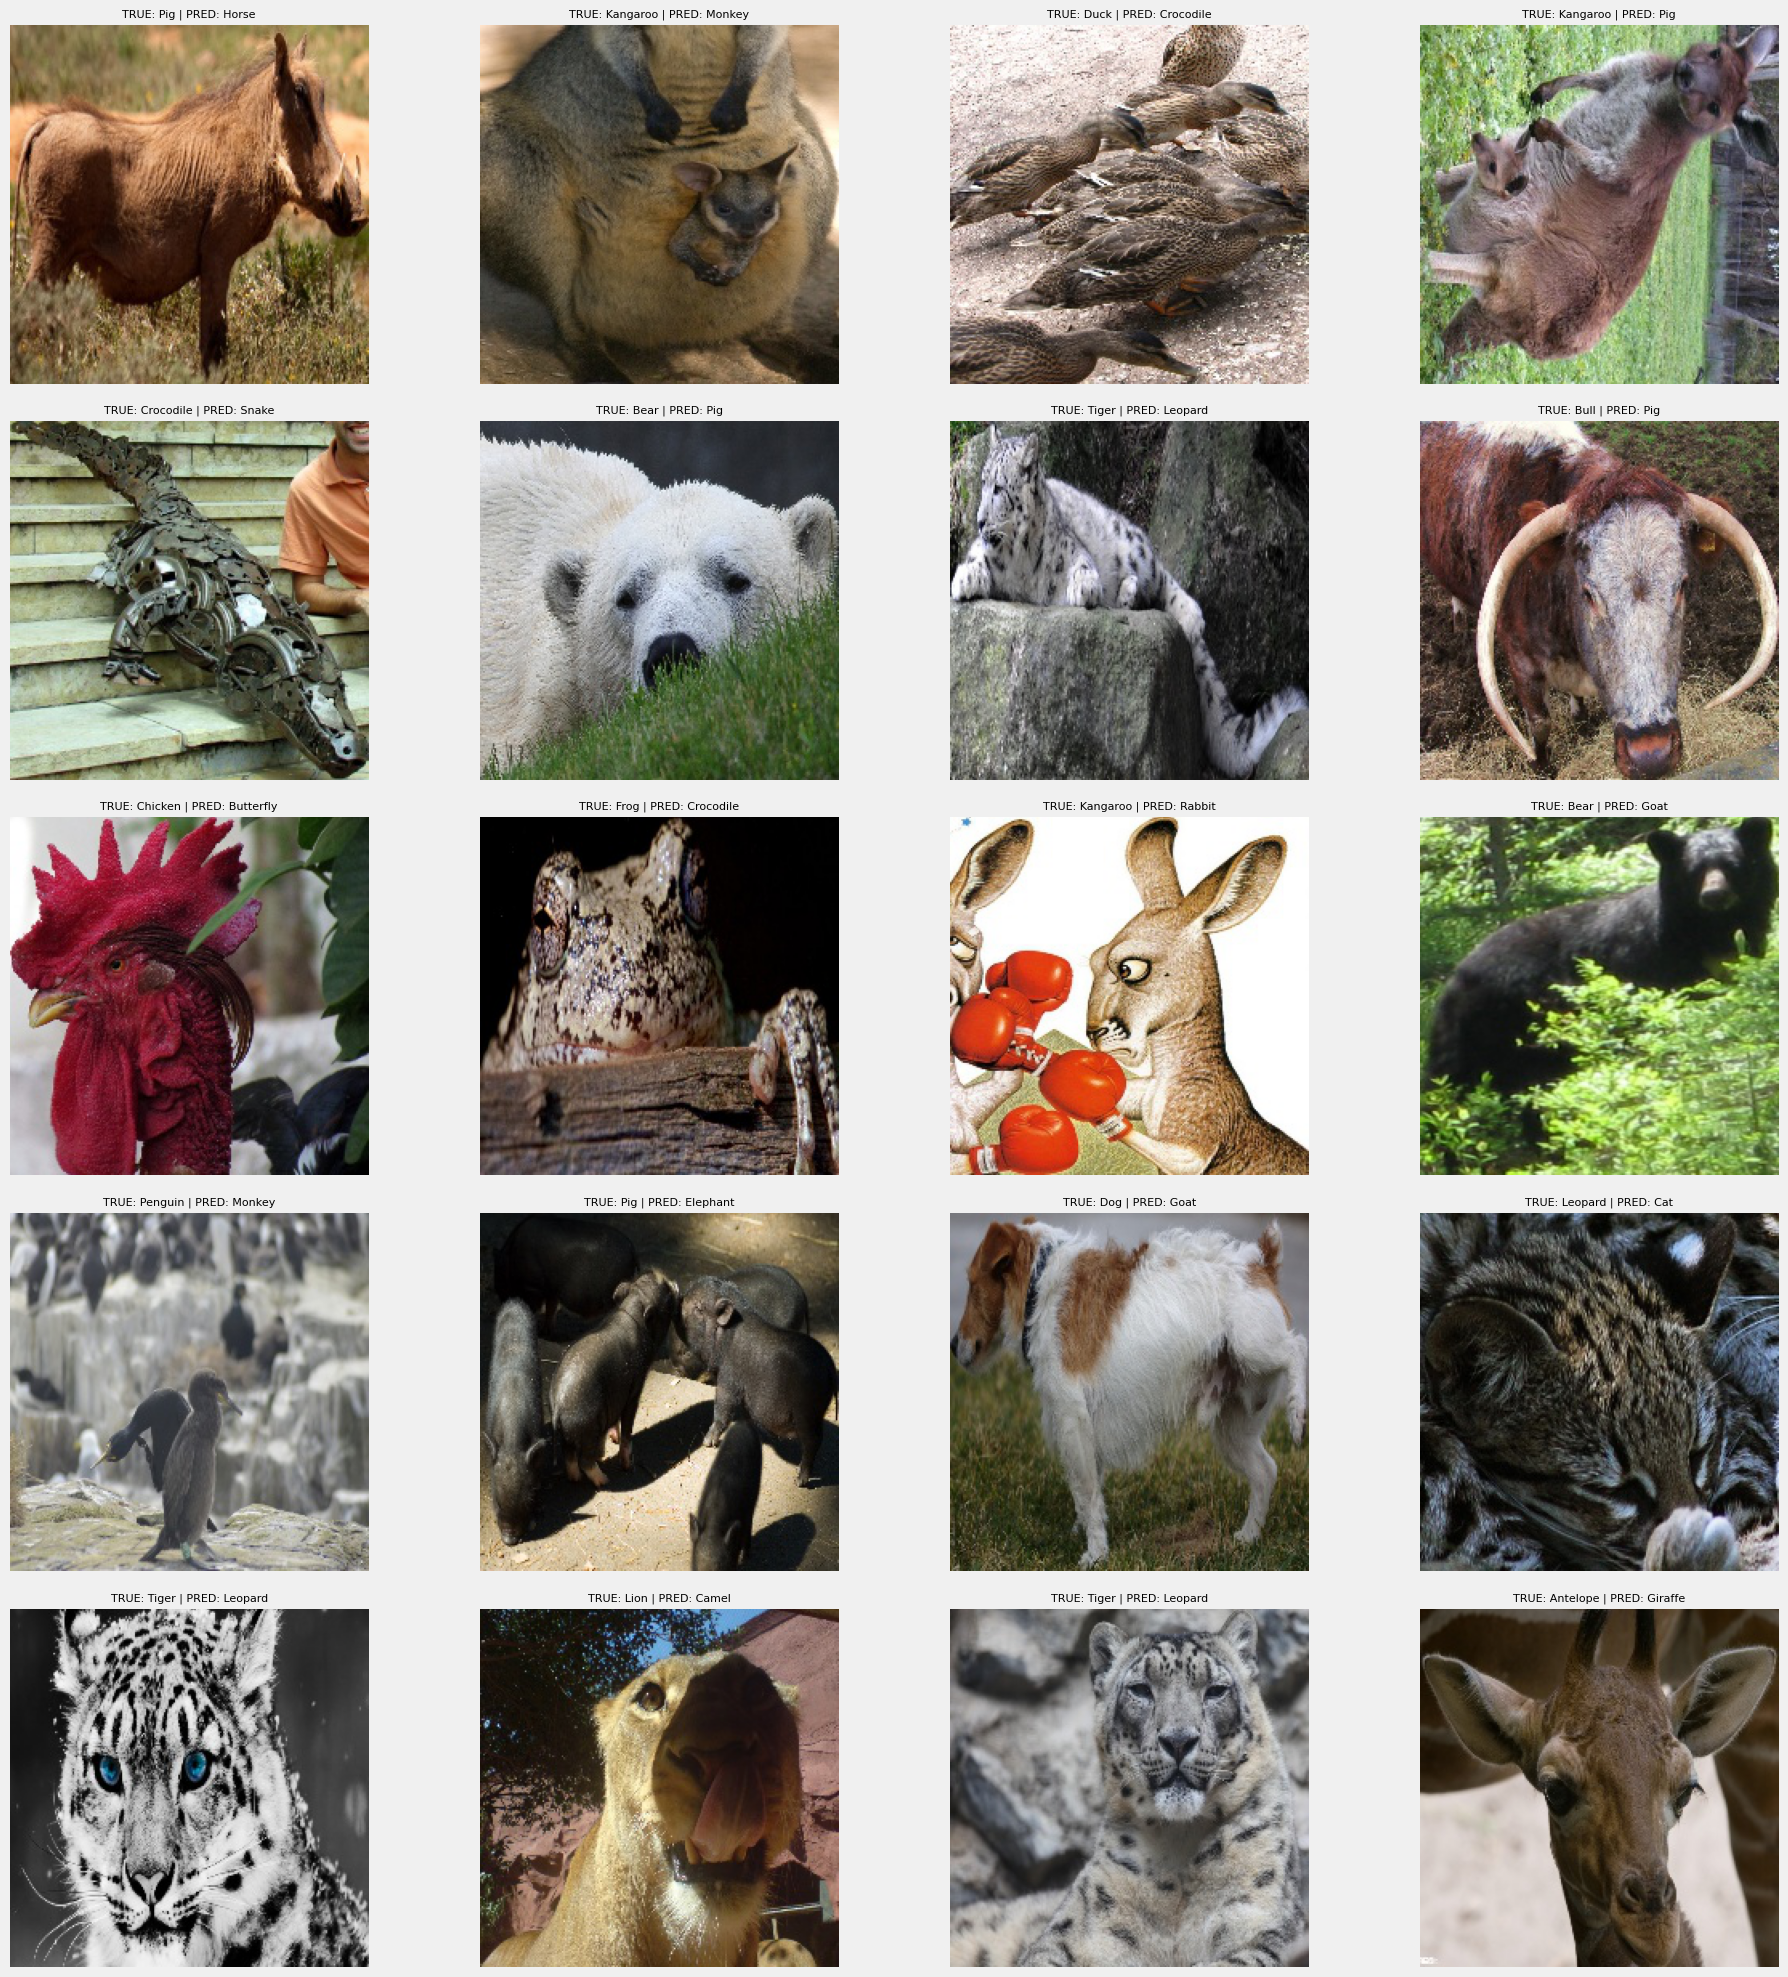

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(20, 20))

# Lọc các dự đoán sai và sắp xếp theo xác suất dự đoán tăng dần, lấy 20 ảnh cuối
incorrect_predictions = Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]]
incorrect_predictions = incorrect_predictions.sort_values("Prediction Probability").tail(20).reset_index()

# Hiển thị các ảnh dự đoán sai
for i, row in incorrect_predictions.iterrows():
    plt.subplot(5, 4, i + 1)
    image_path = f"{test_generator.directory}/{row['Path']}"
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

45/45 [==============================] - 4s 89ms/step


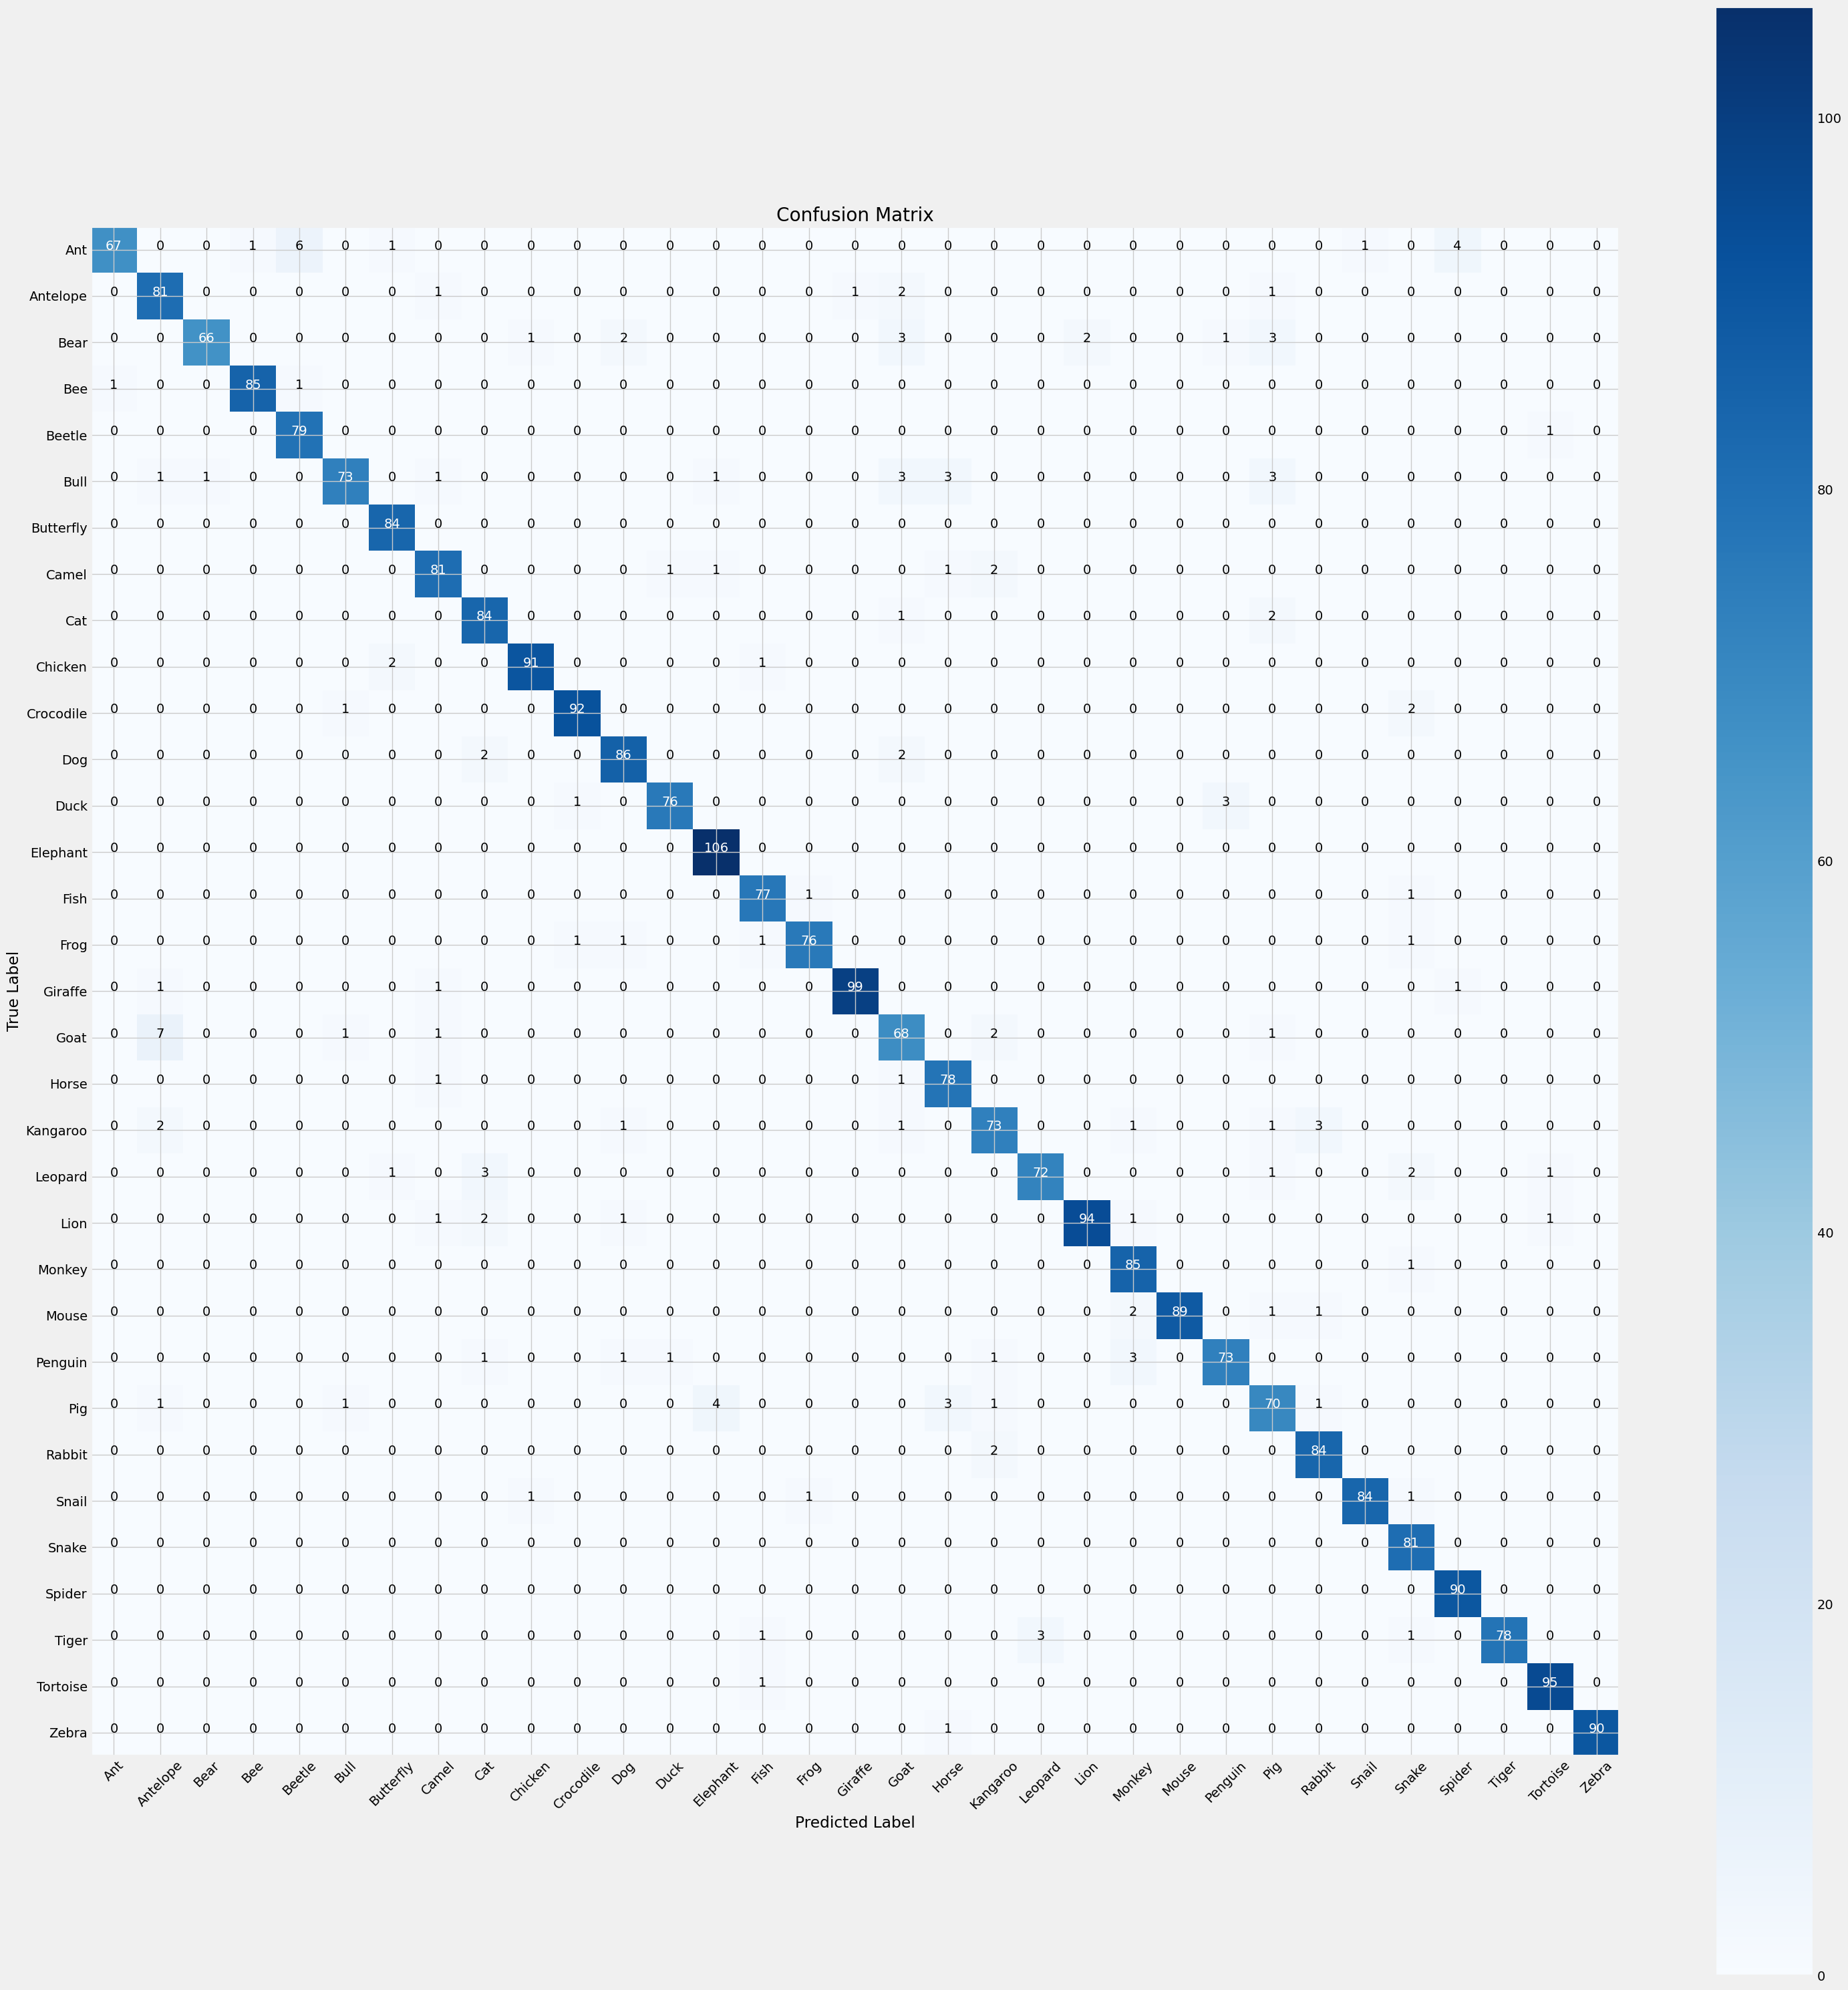

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Dự đoán nhãn trên tập kiểm tra
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

# Tạo danh sách các tên lớp
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Tính confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Vẽ confusion matrix
plt.figure(figsize=(30, 30))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Thêm giá trị vào các ô của confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
# Load mô hình đã lưu
model = load_model('animal_mobilenetv2_model.h5')

def preprocess_image(img_path):
    # Load ảnh và thay đổi kích thước về 224x224
    img = image.load_img(img_path, target_size=(224, 224))
    # Chuyển ảnh thành mảng numpy và chuẩn hóa
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
    img_array /= 255.0  # Rescale giống như khi huấn luyện
    return img_array

def predict_image(img_path):
    # Tiền xử lý ảnh
    img_array = preprocess_image(img_path)
    # Dự đoán
    predictions = model.predict(img_array)
    # Lấy chỉ số lớp dự đoán cao nhất
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    return predicted_class, confidence

In [ ]:
img_path = 'image/panda.jpg'  # Đường dẫn đến ảnh cần dự đoán
predicted_class, confidence = predict_image(img_path)

print(f"Dự đoán lớp: {predicted_class}")
print(f"Độ tin cậy: {confidence*100:.2f}%")

In [ ]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

print("Các lớp có trong thư mục của bạn:")
for i, class_name in enumerate(classes):
    print(f"Lớp {i}: {class_name}")